In [19]:
# https://medium.com/analytics-vidhya/algorithmic-momentum-trading-strategy-747e726d04b4
!pip install quantstats yfinance python-binance pandas_ta ta shap
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
%matplotlib inline
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
import pandas_ta as pta

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
import graphviz

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.ensemble import RandomForestClassifier




api_key = ""
api_secret = ""
client = Client(api_key, api_secret)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Get data

In [20]:
price = yf.download('goog','1993-01-01','2022-12-29')
price.Close.pct_change().shift(1)

[*********************100%***********************]  1 of 1 completed


Date
2004-08-19         NaN
2004-08-20         NaN
2004-08-23    0.079430
2004-08-24    0.010064
2004-08-25   -0.041408
                ...   
2022-06-01    0.010993
2022-06-02    0.000859
2022-06-03    0.031620
2022-06-06   -0.027024
2022-06-07    0.021355
Name: Close, Length: 4482, dtype: float64

# Indicators functions

In [21]:
def moving_average(df, periods):
  df['MA'] = df['Close'].rolling(periods).mean()
  return df

In [22]:
def rs_oldi(df, periods = 14, ema = True):
  df['rsi'] = pta.rsi(df['Close'], length = periods)
  return df

In [23]:
def stochastic_oscillator(df, periods):

  high_roll = df["High"].rolling(periods).max()
  low_roll = df["Low"].rolling(periods).min()

  # Fast stochastic indicator
  num = df["Close"] - low_roll
  denom = high_roll - low_roll
  df["%K"] = (num / denom) * 100

  # Slow stochastic indicator
  df["%D"] = df["%K"].rolling(3).mean()

  return df

In [24]:
def psl(df, periods):
  df['psl'] = pta.psl(df['Close'], length = periods)
  return df

In [25]:
def rvi(df, periods):
  df['rvi'] = pta.rvi(df['Close'], length = periods)
  return df

In [26]:
def true_range(df, periods):
  df['true_range'] = pta.true_range(df['High'], df['Low'], df['Close'], length = periods,)
  return df

In [27]:
def pvt(df):
  df['pvt'] = pta.pvt(df['Close'], df['Volume'])
  return df


In [28]:
def pvr(df):
  df['pvr'] = pta.pvr(df['Close'], df['Volume'],)
  return df


In [29]:
def mfi(df):
  df['mfi'] = pta.mfi(df['High'], df['Low'],df['Close'], df['Volume'], )
  return df


In [30]:
def add_indicators(df, periods):
  df = moving_average(df, periods)
  df = rs_oldi(df, periods = 14, ema = True)
  df = stochastic_oscillator(df, periods)
  df = psl(df, periods)
  df = rvi(df, periods)
  df = true_range(df, periods)
  df = pvt(df)
  df = pvr(df)
  df = mfi(df)
  df = df.dropna()
  return df


In [31]:
def make_target(df):
  dff = df.copy()
  dff['returns'] = dff.Close.pct_change()
  dff['target'] = np.where(dff.returns>0, 1, np.where(dff.returns == 0, 2, 0))
  # y= np.where(df['Close'].shift(-1)>df['Close'],1,-1)
  return dff[['Close','returns','target']]

In [32]:
def make_target(df):
  y= np.where(df['Close'].shift(-1)>df['Close'],1,-1)
  where_are_NaNs = np.isnan(y)
  y[where_are_NaNs] = 0
  return y



In [33]:
def drop_na(df):
  return df.dropna()


# Feature Selection

Text(0.5, 0, 'Random Forest Feature Importance')

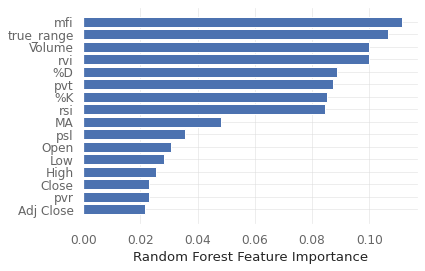

In [34]:
# https://mljar.com/blog/feature-importance-in-random-forest/#:~:text=Random%20Forest%20Built%2Din%20Feature%20Importance&text=It%20is%20a%20set%20of,sets%20with%20similars%20responses%20within.
prices_indicarors = add_indicators(price, 30)

y = make_target(prices_indicarors)

X = pd.DataFrame(prices_indicarors, columns=prices_indicarors.columns)


X_small = X.iloc[:int(X.shape[0]*0.8)]
y_small = y[:int(y.shape[0]*0.8)]

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(prices_indicarors.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# KNN
https://blog.quantinsti.com/machine-learning-k-nearest-neighbors-knn-algorithm-python/

In [35]:
# Instantiate KNN learning model(k=15)
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model
knn.fit(X_train, y_train)

# Accuracy Score
accuracy_train = accuracy_score(y_train, knn.predict(X_train))
accuracy_test = accuracy_score(y_test, knn.predict(X_test))

print ('Train_data Accuracy: %.2f' %accuracy_train)
print ('Test_data Accuracy: %.2f' %accuracy_test)

Train_data Accuracy: 0.61
Test_data Accuracy: 0.52


In [36]:
# KNN without low rate features
# Instantiate KNN learning model(k=15)
knn = KNeighborsClassifier(n_neighbors=10)
X_train = X_train.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
X_test = X_test.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

knn = KNeighborsClassifier(n_neighbors=20)

# fit the model
knn.fit(X_train, y_train)

# Accuracy Score
accuracy_train = accuracy_score(y_train, knn.predict(X_train))
accuracy_test = accuracy_score(y_test, knn.predict(X_test))

print ('Train_data Accuracy: %.2f' %accuracy_train)
print ('Test_data Accuracy: %.2f' %accuracy_test)

Train_data Accuracy: 0.60
Test_data Accuracy: 0.50



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

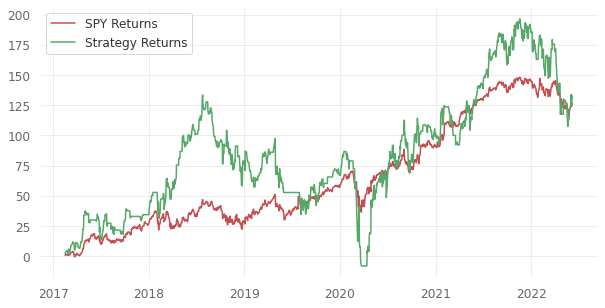

In [37]:
# Predicted Signal
# prices_indicarors = add_indicators(price, 30)

prices_indicarors['Predicted_Signal'] = knn.predict(X.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']))
# prices_indicarors['Predicted_Signal'] = knn.predict(X)
split_percentage = 0.7
split = int(split_percentage*len(prices_indicarors))
# SPY Cumulative Returns
prices_indicarors['returns'] = prices_indicarors.Close.pct_change()
Cumulative_returns = prices_indicarors[split:]['returns'].cumsum()*100

# Cumulative Strategy Returns 
action = []
for index, row in prices_indicarors.iterrows():
  if row.Predicted_Signal == 1:
    action.append(3)
  else:
    action.append(0)

prices_indicarors['action'] = action

prices_indicarors['Startegy_returns'] = prices_indicarors['returns'] * prices_indicarors['action']
Cumulative_Strategy_returns = prices_indicarors[split:]['Startegy_returns'].cumsum()*100

# Plot the results to visualize the performance

plt.figure(figsize=(10,5))
plt.plot(Cumulative_returns, color='r',label = 'SPY Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

# Decision Tree
https://blog.quantinsti.com/decision-tree/

In [38]:
def des_tree(prices_indicarors, predictors_list, depth, leafs):
  X = prices_indicarors[predictors_list]
  y_cls = make_target(prices_indicarors)

  y=y_cls
  print(y)
  X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=0.3, random_state=432, stratify=y)

  print (X_cls_train.shape, y_cls_train.shape)
  print (X_cls_test.shape, y_cls_test.shape)
  clf = DecisionTreeClassifier(criterion='gini', max_depth=depth, min_samples_leaf=leafs)
  clf = clf.fit(X_cls_train, y_cls_train)
  # dot_data = tree.export_graphviz(clf, out_file=None,filled=True,feature_names=predictors_list)
  # graphviz.Source(dot_data)
  y_cls_pred = clf.predict(X_cls_test)
  report = classification_report(y_cls_test, y_cls_pred)
  print(report)
  return y_cls_pred

# plot_retuns(prices_indicarors, des_tree(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

In [39]:
prices_indicarors = add_indicators(price, 30)
prices_indicarors['return'] = price.Close.pct_change().shift(1)
prices_indicarors.head()
prices_indicarors


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,MA,rsi,%K,%D,psl,rvi,true_range,pvt,pvr,mfi,return
Date,,,,,,,,,,,,,,,,,
2004-10-04,67.372475,68.179443,66.764748,67.277824,67.277824,13084661,56.191381,80.823583,95.228059,91.529733,70.000000,13.702702,2.136986,5.512138e+08,2.0,79.111752,0.022994
2004-10-05,67.078575,69.006348,65.873093,68.926643,68.926643,15044379,56.672411,82.763207,99.595842,96.020380,70.000000,20.521805,3.133255,5.880840e+08,1.0,79.915586,0.018706
2004-10-06,68.518173,68.966499,67.746071,68.284058,68.284058,13445007,57.207240,79.392861,96.337472,97.053791,70.000000,18.844187,1.220428,5.755496e+08,4.0,80.608900,0.024508
2004-10-07,68.204353,69.678825,68.020042,69.165749,69.165749,14182160,57.752695,80.562489,97.484123,97.805813,70.000000,25.678482,1.658783,5.938617e+08,1.0,81.313719,-0.009323
2004-10-08,69.100990,69.579201,68.254166,68.607841,68.607841,11122133,58.247839,77.562551,94.748421,96.190005,66.666667,23.481866,1.325035,5.848904e+08,4.0,75.078690,0.012912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,2298.629883,2347.979980,2271.010010,2282.739990,2282.739990,1431500,2308.787996,47.732789,40.144029,38.533199,43.333333,48.226792,76.969971,5.544475e+09,2.0,54.674940,0.010993
2022-06-02,2283.760010,2357.959961,2266.159912,2354.919922,2354.919922,1373600,2301.788330,53.193528,55.296351,45.084874,46.666667,50.425861,91.800049,5.548818e+09,2.0,62.376534,0.000859
2022-06-03,2319.850098,2327.290039,2273.360107,2291.280029,2291.280029,1252600,2294.872664,48.392867,53.157803,49.532728,46.666667,48.416366,81.559814,5.545433e+09,4.0,56.355646,0.031620


In [40]:
def plot_retuns(prices_indicarors, predictions, leverage):
  split_percentage = 0.7
  split = int(split_percentage*len(prices_indicarors))
  # SPY Cumulative Returns
  prices_indicarors = prices_indicarors[split:]
  prices_indicarors['returns'] = prices_indicarors.Close.pct_change()
  Cumulative_returns = prices_indicarors['returns'].cumsum()*100
  prices_indicarors['Predicted_Signal'] = predictions
  # Cumulative Strategy Returns 
  action = []
  for index, row in prices_indicarors.iterrows():
    if row.Predicted_Signal == 1:
      action.append(leverage)
    else:
      action.append(0)

  prices_indicarors['action'] = action

  prices_indicarors['Startegy_returns'] = prices_indicarors['returns'] * prices_indicarors['action']
  prices_indicarors.to_csv("asd.csv")
  Cumulative_Strategy_returns = prices_indicarors['Startegy_returns'].cumsum()*100
  # Plot the results to visualize the performance

  plt.figure(figsize=(10,5))
  plt.plot(Cumulative_returns, color='r',label = 'SPY Returns')
  plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
  plt.legend()
  plt.show()


In [41]:
def plot_retuns_with_short(prices_indicarors, predictions, leverage):
  split_percentage = 0.7
  split = int(split_percentage*len(prices_indicarors))
  # SPY Cumulative Returns
  prices_indicarors = prices_indicarors[split:]
  prices_indicarors['returns'] = prices_indicarors.Close.pct_change()
  Cumulative_returns = prices_indicarors['returns'].cumsum()*100
  prices_indicarors['Predicted_Signal'] = predictions
  # Cumulative Strategy Returns 
  action = []
  for index, row in prices_indicarors.iterrows():
    if row.Predicted_Signal == 1:
      action.append(leverage)
    elif row.Predicted_Signal == -1:
      action.append(-leverage)
    else:
      action.append(100000000)

  prices_indicarors['action'] = action

  prices_indicarors['Startegy_returns'] = prices_indicarors['returns'] * prices_indicarors['action']
  
  Cumulative_Strategy_returns = prices_indicarors['Startegy_returns'].cumsum()*100
  prices_indicarors['Cumulative_Strategy_returns'] = Cumulative_Strategy_returns
  prices_indicarors.to_csv("asd.csv")
  # Plot the results to visualize the performance

  plt.figure(figsize=(10,5))
  plt.plot(Cumulative_returns, color='r',label = 'SPY Returns')
  plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
  plt.legend()
  plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[ 1 -1  1 ...  1  1 -1]
(3115, 10) (3115,)
(1336, 10) (1336,)
              precision    recall  f1-score   support

          -1       0.56      0.01      0.03       635
           1       0.53      0.99      0.69       701

    accuracy                           0.53      1336
   macro avg       0.54      0.50      0.36      1336
weighted avg       0.54      0.53      0.37      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


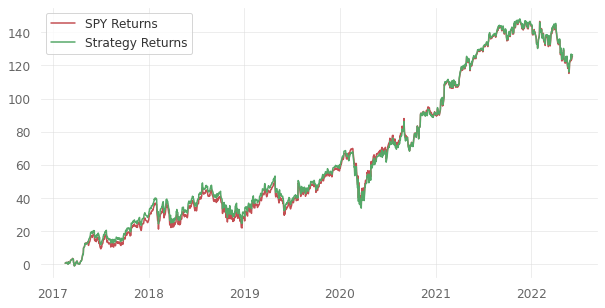

In [42]:
predictors_list = ['MA', 'rsi', '%K', '%D', 'psl', 'rvi', 'true_range', 'pvt', 'pvr', 'mfi']
tree_depth = 3
leaths = 6
leverage = 1
plot_retuns(prices_indicarors, des_tree(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

[ 1 -1  1 ...  1  1 -1]
(3115, 3) (3115,)
(1336, 3) (1336,)
              precision    recall  f1-score   support

          -1       0.50      0.36      0.42       635
           1       0.54      0.68      0.60       701

    accuracy                           0.53      1336
   macro avg       0.52      0.52      0.51      1336
weighted avg       0.52      0.53      0.51      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

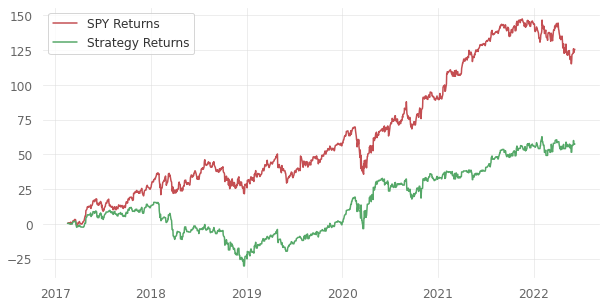

In [43]:
predictors_list = ['Volume', 'true_range','mfi']
tree_depth = 3
leaths = 6
leverage = 1
plot_retuns(prices_indicarors, des_tree(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

[ 1 -1  1 ...  1  1 -1]
(3115, 7) (3115,)
(1336, 7) (1336,)
              precision    recall  f1-score   support

          -1       0.56      0.01      0.03       635
           1       0.53      0.99      0.69       701

    accuracy                           0.53      1336
   macro avg       0.54      0.50      0.36      1336
weighted avg       0.54      0.53      0.37      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

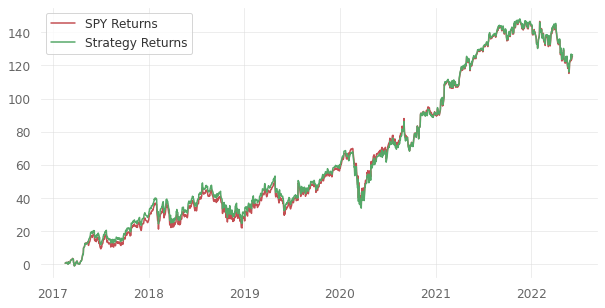

In [44]:
predictors_list = ['MA', 'rsi', '%D', 'rvi', 'pvt', 'pvr', 'Volume']
tree_depth = 3
leaths = 6
leverage = 1
plot_retuns(prices_indicarors, des_tree(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

# Random Forest

In [45]:
prices_indicarors = add_indicators(price, 30)
prices_indicarors['return'] = price.Close.pct_change().shift(1).dropna()
prices_indicarors.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,MA,rsi,%K,%D,psl,rvi,true_range,pvt,pvr,mfi,return
Date,,,,,,,,,,,,,,,,,
2004-10-04,67.372475,68.179443,66.764748,67.277824,67.277824,13084661,56.191381,80.823583,95.228059,91.529733,70.000000,13.702702,2.136986,5.512138e+08,2.0,79.111752,0.022994
2004-10-05,67.078575,69.006348,65.873093,68.926643,68.926643,15044379,56.672411,82.763207,99.595842,96.020380,70.000000,20.521805,3.133255,5.880840e+08,1.0,79.915586,0.018706
2004-10-06,68.518173,68.966499,67.746071,68.284058,68.284058,13445007,57.207240,79.392861,96.337472,97.053791,70.000000,18.844187,1.220428,5.755496e+08,4.0,80.608900,0.024508
2004-10-07,68.204353,69.678825,68.020042,69.165749,69.165749,14182160,57.752695,80.562489,97.484123,97.805813,70.000000,25.678482,1.658783,5.938617e+08,1.0,81.313719,-0.009323
2004-10-08,69.100990,69.579201,68.254166,68.607841,68.607841,11122133,58.247839,77.562551,94.748421,96.190005,66.666667,23.481866,1.325035,5.848904e+08,4.0,75.078690,0.012912


(3115, 7) (3115,)
(1336, 7) (1336,)
              precision    recall  f1-score   support

          -1       0.50      0.08      0.14       635
           1       0.53      0.93      0.67       701

    accuracy                           0.52      1336
   macro avg       0.51      0.50      0.40      1336
weighted avg       0.51      0.52      0.42      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

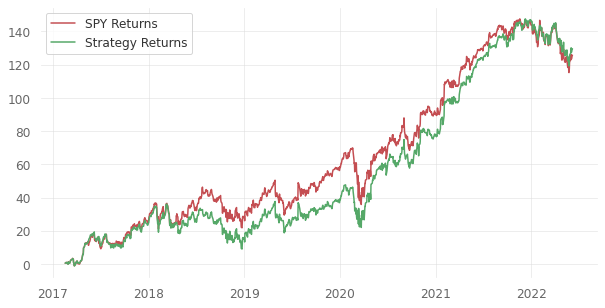

In [46]:
def random_Forest(prices_indicarors, predictors_list, depth, leafs):
  X = prices_indicarors[predictors_list]
  y_cls = make_target(prices_indicarors)

  y=y_cls
  X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=0.3, random_state=432, stratify=y)

  print (X_cls_train.shape, y_cls_train.shape)
  print (X_cls_test.shape, y_cls_test.shape)
  clf = RandomForestClassifier(random_state=5, criterion='gini', max_depth=depth, min_samples_leaf=leafs)
  clf = clf.fit(X_cls_train, y_cls_train)

  y_cls_pred = clf.predict(X_cls_test)
  report = classification_report(y_cls_test, y_cls_pred)
  print(report)
  return y_cls_pred

predictors_list = ['MA', 'rsi', '%D', 'rvi', 'pvt', 'pvr', 'Volume']
tree_depth = 3
leaths = 6
leverage = 1
plot_retuns(prices_indicarors, random_Forest(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

(3115, 3) (3115,)
(1336, 3) (1336,)
              precision    recall  f1-score   support

          -1       0.47      0.06      0.11       635
           1       0.52      0.93      0.67       701

    accuracy                           0.52      1336
   macro avg       0.49      0.50      0.39      1336
weighted avg       0.50      0.52      0.41      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

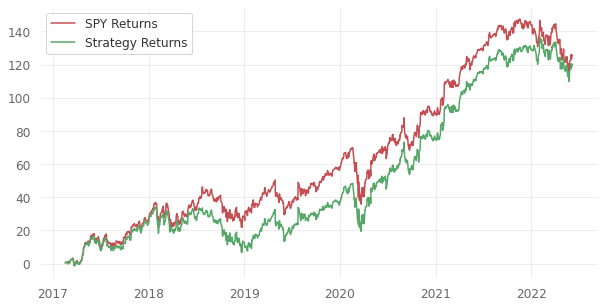

In [47]:
predictors_list = ['Volume', 'true_range','mfi']
tree_depth = 3
leaths = 6
leverage = 1
plot_retuns(prices_indicarors, random_Forest(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

(3115, 2) (3115,)
(1336, 2) (1336,)
              precision    recall  f1-score   support

          -1       0.52      0.09      0.15       635
           1       0.53      0.93      0.67       701

    accuracy                           0.53      1336
   macro avg       0.53      0.51      0.41      1336
weighted avg       0.53      0.53      0.42      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

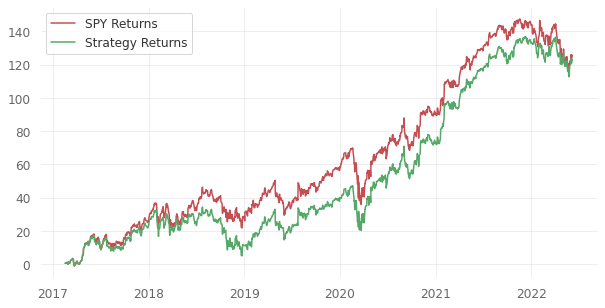

In [48]:
predictors_list = ['Volume','mfi']
tree_depth = 3
leaths = 6
leverage = 1
plot_retuns(prices_indicarors, random_Forest(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

(3115, 1) (3115,)
(1336, 1) (1336,)
              precision    recall  f1-score   support

          -1       0.45      0.04      0.07       635
           1       0.52      0.96      0.68       701

    accuracy                           0.52      1336
   macro avg       0.49      0.50      0.37      1336
weighted avg       0.49      0.52      0.39      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

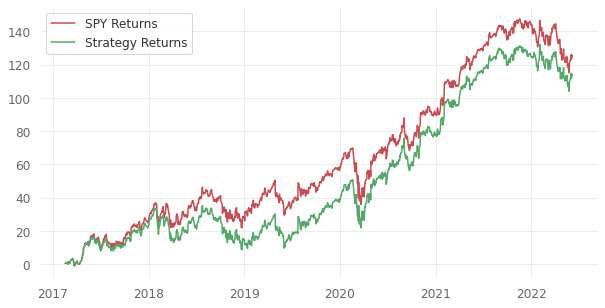

In [49]:
predictors_list = ['mfi']
tree_depth = 1
leafs = 3
leverage = 1
plot_retuns(prices_indicarors, random_Forest(prices_indicarors, predictors_list, tree_depth, leafs), leverage)

(3115, 2) (3115,)
(1336, 2) (1336,)
              precision    recall  f1-score   support

          -1       0.52      0.09      0.15       635
           1       0.53      0.93      0.67       701

    accuracy                           0.53      1336
   macro avg       0.53      0.51      0.41      1336
weighted avg       0.53      0.53      0.42      1336




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

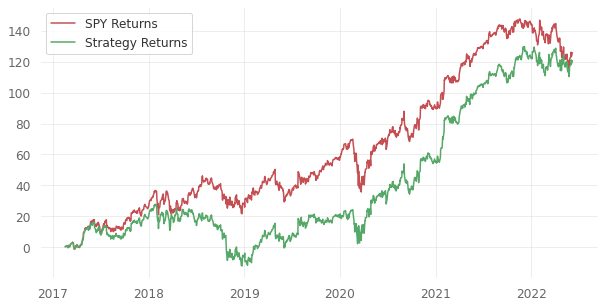

In [50]:
# try with short
predictors_list = ['Volume','mfi']
tree_depth = 3
leaths = 6
leverage = 1
plot_retuns_with_short(prices_indicarors, random_Forest(prices_indicarors, predictors_list, tree_depth, leaths), leverage)

# deep neural network 

In [51]:
prices_indicarors = add_indicators(price, 30)
prices_indicarors['return'] = price.Close.pct_change().shift(1).dropna()
prices_indicarors.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,MA,rsi,%K,%D,psl,rvi,true_range,pvt,pvr,mfi,return
Date,,,,,,,,,,,,,,,,,
2004-10-04,67.372475,68.179443,66.764748,67.277824,67.277824,13084661,56.191381,80.823583,95.228059,91.529733,70.000000,13.702702,2.136986,5.512138e+08,2.0,79.111752,0.022994
2004-10-05,67.078575,69.006348,65.873093,68.926643,68.926643,15044379,56.672411,82.763207,99.595842,96.020380,70.000000,20.521805,3.133255,5.880840e+08,1.0,79.915586,0.018706
2004-10-06,68.518173,68.966499,67.746071,68.284058,68.284058,13445007,57.207240,79.392861,96.337472,97.053791,70.000000,18.844187,1.220428,5.755496e+08,4.0,80.608900,0.024508
2004-10-07,68.204353,69.678825,68.020042,69.165749,69.165749,14182160,57.752695,80.562489,97.484123,97.805813,70.000000,25.678482,1.658783,5.938617e+08,1.0,81.313719,-0.009323
2004-10-08,69.100990,69.579201,68.254166,68.607841,68.607841,11122133,58.247839,77.562551,94.748421,96.190005,66.666667,23.481866,1.325035,5.848904e+08,4.0,75.078690,0.012912


In [66]:
X = prices_indicarors
y = make_target(prices_indicarors)

In [53]:
split = int(len(price)*0.7)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [54]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [55]:
classifier = Sequential()


In [56]:
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)


Epoch 1/100
314/314 [==============================] - 2s 3ms/step - loss: 1.0249 - accuracy: 0.0099
Epoch 2/100
314/314 [==============================] - 1s 3ms/step - loss: 0.9972 - accuracy: 0.0000e+00
Epoch 3/100
314/314 [==============================] - 1s 3ms/step - loss: 0.9968 - accuracy: 0.0000e+00
Epoch 4/100
314/314 [==============================] - 1s 3ms/step - loss: 0.9959 - accuracy: 0.0000e+00
Epoch 5/100
314/314 [==============================] - 1s 3ms/step - loss: 0.9954 - accuracy: 0.0000e+00
Epoch 6/100
314/314 [==============================] - 1s 3ms/step - loss: 0.9942 - accuracy: 0.0000e+00
Epoch 7/100
314/314 [==============================] - 1s 3ms/step - loss: 0.9934 - accuracy: 0.0000e+00
Epoch 8/100
314/314 [==============================] - 1s 3ms/step - loss: 0.9937 - accuracy: 0.0000e+00
Epoch 9/100
314/314 [==============================] - 1s 3ms/step - loss: 0.9934 - accuracy: 0.0000e+00
Epoch 10/100
314/314 [==============================] - 1s 

In [70]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
pd.DataFrame(y_pred)

array([False])

In [72]:
price['y_pred'] = np.NaN
price.iloc[(len(price) - len(y_pred)):,-1:] = y_pred
trade_dataset = price.dropna()
trade_dataset

,Open,High,Low,Close,Adj Close,Volume,MA,rsi,%K,%D,psl,rvi,true_range,pvt,pvr,mfi,y_pred
Date,,,,,,,,,,,,,,,,,
2017-03-21,851.400024,853.500000,829.020020,830.460022,830.460022,2463500,830.480668,47.751621,55.452453,81.550917,70.000000,65.170239,24.479980,5.514402e+09,3.0,58.271427,False
2017-03-22,831.909973,835.549988,827.179993,829.590027,829.590027,1401500,831.234670,47.026962,52.474708,66.442904,66.666667,61.518244,8.369995,5.514255e+09,4.0,56.818387,False
2017-03-23,821.000000,822.570007,812.257019,817.580017,817.580017,3487100,831.541337,38.370278,26.634055,44.853739,63.333333,58.191201,17.333008,5.509207e+09,3.0,49.923516,False
2017-03-24,820.080017,821.929993,808.890015,814.429993,814.429993,1981000,831.703670,36.473828,12.418695,30.509153,60.000000,55.095113,13.039978,5.508444e+09,4.0,47.994103,False
2017-03-27,806.950012,821.630005,803.369995,819.510010,819.510010,1894300,831.898338,41.495747,32.196316,23.749689,60.000000,57.448659,18.260010,5.509626e+09,2.0,41.652324,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,2298.629883,2347.979980,2271.010010,2282.739990,2282.739990,1431500,2308.787996,47.732789,40.144029,38.533199,43.333333,48.226792,76.969971,5.544475e+09,2.0,54.674940,False
2022-06-02,2283.760010,2357.959961,2266.159912,2354.919922,2354.919922,1373600,2301.788330,53.193528,55.296351,45.084874,46.666667,50.425861,91.800049,5.548818e+09,2.0,62.376534,False
2022-06-03,2319.850098,2327.290039,2273.360107,2291.280029,2291.280029,1252600,2294.872664,48.392867,53.157803,49.532728,46.666667,48.416366,81.559814,5.545433e+09,4.0,56.355646,False


In [59]:
trade_dataset['Tomorrows Returns'] = 0.
trade_dataset['Tomorrows Returns'] = np.log(trade_dataset['Close']/trade_dataset['Close'].shift(1))
trade_dataset['Tomorrows Returns'] = trade_dataset['Tomorrows Returns'].shift(-1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
trade_dataset['Strategy Returns'] = 0.
trade_dataset['Strategy Returns'] = np.where(trade_dataset['y_pred'] == True, trade_dataset['Tomorrows Returns'], - trade_dataset['Tomorrows Returns'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [61]:
trade_dataset['Cumulative Market Returns'] = np.cumsum(trade_dataset['Tomorrows Returns'])
trade_dataset['Cumulative Strategy Returns'] = np.cumsum(trade_dataset['Strategy Returns'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


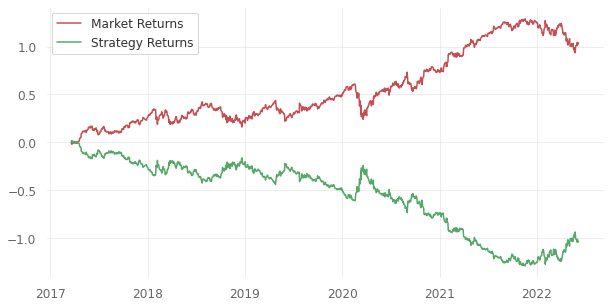

In [62]:
plt.figure(figsize=(10,5))
plt.plot(trade_dataset['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(trade_dataset['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()

# Summery 

In [63]:
# From the data it look like Random Forest make best results with 1 depth and 3 leafs